In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
import warnings

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv1D, Conv2D, Flatten, MaxPool1D, MaxPool2D

In [2]:
warnings.filterwarnings('ignore')

In [3]:
(X_train, y_train), (X_test, y_test) = \
tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# (X_train_alt, y_train_alt), (X_test_alt, y_test_alt) =tf.keras.datasets.fashion_mnist.load_data()

In [5]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


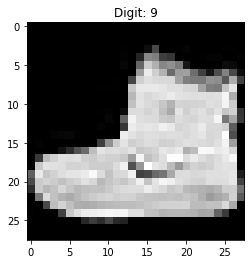

In [6]:
plt.figure()
plt.title(label=f'Digit: {y_train[0]}')
plt.imshow(X=X_train[0], cmap='gray')

In [7]:
def pad(arr: np.ndarray, h_pad: int = 0, v_pad: int = 0):
    rows = len(arr)

    horizontal_pad = np.zeros(shape=(rows, arr.shape[1], h_pad))
    vertical_pad = np.zeros(shape=(rows, v_pad, arr.shape[2] + h_pad * 2))

    arr_copy = np.concatenate((horizontal_pad, arr, horizontal_pad), axis=2)
    arr_copy = np.concatenate((vertical_pad, arr_copy, vertical_pad), axis=1)

    return arr_copy


In [8]:
# def sort_columns_hilbert_old(arr, cache=None):
#     arr_copy = arr.copy()
#     rows = len(arr_copy)

#     arr_shape = arr.shape

#     from math import log2

#     if cache is None:
#         from hilbertcurve.hilbertcurve import HilbertCurve
#         hcurve = HilbertCurve(log2(arr_shape[1]), 2)
#         h_arr = np.array(hcurve.points_from_distances(range(arr_shape[1] ** 2)))
#         arr_resorted = np.empty(shape=(rows, 0))
#         for i, (r, c) in enumerate(h_arr):
#             arr_resorted = np.concatenate((arr_resorted, arr_copy[:, r, c].reshape(-1, 1)), axis=1)
#             print(f'\ri={i};r={r};c={c}', end='')
#         arr_resorted.shape
#     else:
#         import pickle
#         with open(file=cache, mode='rb') as f:
#             arr_resorted = pickle.load(f)
    
#     return arr_resorted

In [9]:
def sort_columns_hilbert(arr):
    arr_copy = arr.copy()
    arr_shape = arr.shape

    assert arr_shape[1] == arr_shape[2], f"Samples must have square dimensions: {arr_shape[1]} != {arr_shape[2]}"

    from math import log2
    from hilbertcurve.hilbertcurve import HilbertCurve

    hcurve = HilbertCurve(log2(arr_shape[1]), 2)
    h_arr = np.array(hcurve.points_from_distances(range(arr_shape[1] ** 2)))
    mask = h_arr[:, 0] * arr_shape[1] + h_arr[:, 1]
    arr_resorted = arr_copy.reshape(-1, arr_shape[1] ** 2)[:, mask]
    
    return arr_resorted

In [10]:
def revert_columns_hilbert(arr):
    arr_copy = arr.copy()
    arr_shape = arr.shape

    assert len(arr_shape) == 2, f"Samples must be 1-Dimensional"
    assert arr_shape[1] ** 0.5 == int(arr_shape[1] ** 0.5), f"Sample length must be a square number"

    from math import log2
    from hilbertcurve.hilbertcurve import HilbertCurve

    side_length = int(arr_shape[1] ** 0.5)
    hcurve = HilbertCurve(int(side_length), 2)
    h_arr = np.array(hcurve.points_from_distances(range(arr_shape[1])))
    mask_transform = h_arr[:, 0] * side_length + h_arr[:, 1]
    mask = np.empty(shape=(arr_shape[1],), dtype=int)
    mask[mask_transform] = np.arange(arr_shape[1])
    arr_resorted = arr_copy[:, mask].reshape(-1, side_length, side_length)
    if int(log2(side_length)) % 2 == 1:
        return arr_resorted.transpose((0, 2, 1))
    return arr_resorted

In [11]:
# np.random.seed(2)
# for i in range(1, 10):
#     A = np.random.randint(0, 10, size=(3, 2 ** i, 2 ** i))
#     print(2 ** i, np.abs(A - revert_columns_hilbert(sort_columns_hilbert(A))).sum())

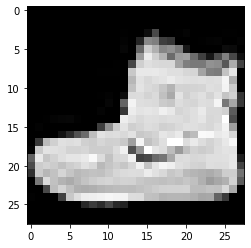

In [12]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')

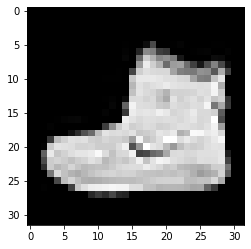

In [13]:
plt.imshow(pad(X_train, 2, 2)[0].reshape(32, 32), cmap='gray')

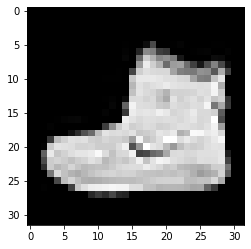

In [14]:
plt.imshow(revert_columns_hilbert(sort_columns_hilbert(pad(X_train, 2, 2)))[0].reshape(32, 32), cmap='gray')

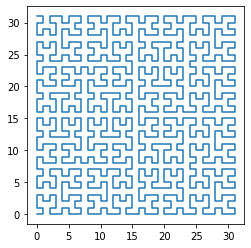

In [51]:
from hilbertcurve.hilbertcurve import HilbertCurve
from math import log2
def show_hilbert_curve(side_length):
    d = np.array(HilbertCurve(log2(side_length) + 1, 2).points_from_distances(range(side_length ** 2))).T
    plt.plot(d[0], d[1])
    plt.xlim(-0.1, side_length ** 2 + 0.1)
    plt.ylim(-0.1, side_length ** 2 + 0.1)
    plt.axis('scaled')
    plt.show()

show_hilbert_curve(32)

In [53]:
def compress(arr, chunk_size=4, agg=np.mean):
    assert len(arr.shape) == 2, "Samples must be 1-Dimensional"
    if chunk_size > 1:
        arr_copy = np.empty(shape=(arr.shape[0], 0))
        for arr_ in np.array_split(ary=arr, indices_or_sections=arr.shape[1] // chunk_size, axis=1):
            arr_copy = np.concatenate((arr_copy, agg(arr_, axis=1).reshape((-1, 1))), axis=1)
        return arr_copy
    else:
        return arr

In [54]:
def save_obj_to_binary(obj, filepath):
    import pickle
    try:
        with open(file=filepath, mode='wb') as f:
            pickle.dump(obj=obj, file=f)
        return 0
    except:
        return 1

In [55]:
def evaluate_model(X_train, y_train, X_test, y_test, model, *args, **kwargs):
    from sklearn.metrics import accuracy_score
    from tensorflow.keras.models import Sequential

    model.fit(X_train, y_train, *args, **kwargs)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    if isinstance(model, Sequential):
        train_pred = train_pred.argmax(axis=1)
        test_pred = test_pred.argmax(axis=1)
        y_train = y_train.argmax(axis=1)
        y_test = y_test.argmax(axis=1)

    acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_test, test_pred)

    return acc, val_acc

In [56]:
def compare_model_scores(cnn_score, logreg_score, kind: str):
    print(f'Comparison of CNN against Logistic Regression ({kind})')
    df = pd.DataFrame(data={
        'CNN': cnn_score,
        'Logistic Regression': logreg_score
    }, index=['Training Accuracy', 'Testing Accuracy'])
    print(df)

In [168]:
def baseline_models(X_train, y_train, X_test, y_test):
    X_train2 = X_train.reshape((60000, 28 * 28))
    X_test2 = X_test.reshape((10000, 28 * 28))

    cnn = Sequential(layers=[
        Dense(10, input_shape=(28 * 28,), activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train2, to_categorical(
        y_train), X_test2, to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train2, y_train, X_test2, y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, 'baseline models')


baseline_models(X_train, y_train, X_test, y_test)


Comparison of CNN against Logistic Regression (baseline models)
                        CNN  Logistic Regression
Training Accuracy  0.796183               0.8632
Testing Accuracy   0.781000               0.8412


In [169]:
def data_normalisation(X_train, y_train, X_test, y_test):
    X_train2 = X_train.reshape((60000, 28 * 28)) / 255.0
    X_test2 = X_test.reshape((10000, 28 * 28)) / 255.0

    cnn = Sequential(layers=[
        Dense(10, input_shape=(28 * 28,), activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train2, to_categorical(
        y_train), X_test2, to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train2, y_train, X_test2, y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, 'data normalisation')

data_normalisation(X_train, y_train, X_test, y_test)

Comparison of CNN against Logistic Regression (data normalisation)
                        CNN  Logistic Regression
Training Accuracy  0.839617              0.86625
Testing Accuracy   0.827000              0.84390


In [170]:
def feature_engineering_simple_agg(X_train, y_train, X_test, y_test):
    X_train2 = X_train.reshape((60000, 28 * 28, 1)) / 255.0
    X_test2 = X_test.reshape((10000, 28 * 28, 1)) / 255.0

    X_train3 = compress(X_train2.reshape(60000, -1), chunk_size=4, agg=np.max)
    X_test3 = compress(X_test2.reshape(10000, -1), chunk_size=4, agg=np.max)

    cnn = Sequential(layers=[
        InputLayer(input_shape=(28 * 28, 1)),
        MaxPool1D(pool_size=(4,), strides=4),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train2, to_categorical(
        y_train), X_test2, to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train3, y_train, X_test3, y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, 'simple aggregation')

feature_engineering_simple_agg(X_train, y_train, X_test, y_test)

Comparison of CNN against Logistic Regression (simple aggregation)
                       CNN  Logistic Regression
Training Accuracy  0.77585             0.823567
Testing Accuracy   0.76360             0.812700


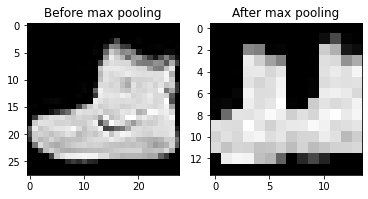

In [59]:
def compare_resolution_after_pooling(X_train, sample=0, kind='max'):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(X_train[sample], cmap='gray')
    ax[0].set_title(f'Before {kind} pooling')
    agg = np.max if kind == 'max' else np.mean
    ax[1].imshow(compress(X_train.reshape(60000, -1), chunk_size=4, agg=agg)[sample].reshape(14, 14), cmap='gray')
    ax[1].set_title(f'After {kind} pooling')
    plt.show()

compare_resolution_after_pooling(X_train, sample=0)

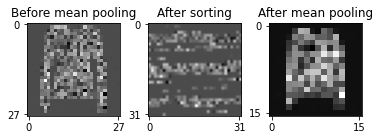

In [72]:
def compare_resolution_after_pooling_with_hilbert(X_train, sample=0, kind='max'):
    noise_c = np.random.normal(0, 1, X_train.shape)
    noise = np.random.normal(1, 1, X_train.shape)
    X_train_noisy = noise * (noise_c + X_train)
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(X_train_noisy[sample], cmap='gray')
    ax[0].set_title(f'Before {kind} pooling')
    ax[0].set_xticks(ticks=(0, 27))
    ax[0].set_yticks(ticks=(0, 27))

    ax[1].imshow(sort_columns_hilbert(pad(X_train_noisy, 2, 2))[sample].reshape(32, 32), cmap='gray')
    ax[1].set_title(f'After sorting')
    ax[1].set_xticks(ticks=(0, 31))
    ax[1].set_yticks(ticks=(0, 31))

    agg = np.max if kind == 'max' else np.mean
    ax[2].imshow(
        revert_columns_hilbert(compress(sort_columns_hilbert(pad(X_train_noisy, 2, 2)), chunk_size=4, agg=agg))[sample].reshape(16, 16), cmap='gray')
    ax[2].set_title(f'After {kind} pooling')
    ax[2].set_xticks(ticks=(0, 15))
    ax[2].set_yticks(ticks=(0, 15))

    plt.subplots_adjust(wspace=0.3)
    plt.show()

compare_resolution_after_pooling_with_hilbert(X_train, sample=1650, kind='mean')

In [85]:
def feature_engineering_hilb_agg(X_train, y_train, X_test, y_test):
    X_train2 = X_train / 255.0
    X_test2 = X_test / 255.0

    X_train3 = revert_columns_hilbert(compress(sort_columns_hilbert(pad(X_train2, 2, 2)), chunk_size=4, agg=np.max))
    X_test3 = revert_columns_hilbert(compress(sort_columns_hilbert(pad(X_test2, 2, 2)), chunk_size=4, agg=np.max))

    cnn = Sequential(layers=[
        InputLayer(input_shape=(16 * 16)),
        Dense(10, activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train3.reshape(60000, -1), to_categorical(
        y_train), X_test3.reshape(10000, -1), to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train3.reshape(60000, -1), y_train, X_test3.reshape(10000, -1), y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, 'hilbert curve aggregation')

feature_engineering_hilb_agg(X_train, y_train, X_test, y_test)

Comparison of CNN against Logistic Regression (hilbert curve aggregation)
                        CNN  Logistic Regression
Training Accuracy  0.781517               0.8350
Testing Accuracy   0.771200               0.8208


In [21]:
cs = 4

X_train3 = compress(
    arr=sort_columns_hilbert(pad(X_train, 2, 2), cache='../models/reordered_train.p'), chunk_size=cs)
X_test3 = compress(
    arr=sort_columns_hilbert(pad(X_test, 2, 2), cache='../models/reordered_test.p'), chunk_size=cs)
evaluate_model(X_train3, y_train, X_test3, y_test,
               LogisticRegression(max_iter=20))


TypeError: sort_columns_hilbert() got an unexpected keyword argument 'cache'

In [ ]:
# def find_best_cs(X_train, X_test, y_train, y_test, start=2, end=32):
#     scores = []
#     for i in range(start, end + 1):
#         print(f'\rIteration {i} / {end}', end='')
#         X_train_ = compress(
#             arr=sort_columns_hilbert(pad(X_train, 2, 2), cache='../models/reordered_train.p'), chunk_size=i)
#         X_test_ = compress(
#             arr=sort_columns_hilbert(pad(X_test, 2, 2), cache='../models/reordered_test.p'), chunk_size=i)
#         scores.append([*evaluate_model(X_train_, y_train, X_test_, y_test,
#                        LogisticRegression(max_iter=10))])
#     return np.array(scores)

# grid_search_chunk_size = find_best_cs(X_train, X_test, y_train, y_test)

Iteration 4 / 32

KeyboardInterrupt: 

In [ ]:
# save_obj_to_binary(obj=grid_search_chunk_size, filepath='../models/grid_search_cs.p')

In [ ]:
sb.lineplot(list(range(grid_search_chunk_size.shape[0])), grid_search_chunk_size[:,0])
sb.lineplot(list(range(grid_search_chunk_size.shape[0])), grid_search_chunk_size[:,1])

In [ ]:
X_test4 = X_test3 / 255.0
X_train4 = X_train3 / 255.0

evaluate_model(X_train4, y_train, X_test4, y_test, LogisticRegression(max_iter=20))